<a href="https://colab.research.google.com/github/skywalker0803r/SCR/blob/main/Modeling(20230915).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch import FloatTensor

In [ ]:
import joblib
test_data = joblib.load('/content/drive/MyDrive/SCR/test_dataset.pkl')
data = joblib.load('/content/drive/MyDrive/SCR/train_dataset.pkl')

In [ ]:
data['state'].shape

(27713, 2, 35)

In [ ]:
data['action'].shape

(27713, 2)

In [ ]:
data['action'] = data['action'].reshape(-1,2,1)
data['action'].shape

(27713, 2, 1)

In [ ]:
data['value'].shape

(27713, 1)

In [ ]:
data_size = len(data['value'])
batch_size = 128
hidden_size = 128
request_size = 1 # 需求產出
state_size = data['state'].shape[-1]
value_size = data['value'].shape[-1] # 實際產出
action_size = data['action'].shape[-1]  #可控制器數量
time_step = 2 #時間窗格

In [ ]:
d = {}
d['state'] = FloatTensor(data['state'])
d['request'] = FloatTensor(torch.rand(data_size,request_size))#(B,r_dim)
d['action'] = FloatTensor(data['action'])
d['value'] = FloatTensor(data['value'])
d = TensorDataset(d['state'],d['request'],d['action'],d['value'])
train_iter = DataLoader(d,batch_size,shuffle=False)

In [ ]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
    self.dropout = nn.Dropout (p = 0.25)

  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = self.dropout(hx)
    x = torch.tanh(x)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step

    self.actor = actor
    self.actor_optimizer = Adam(actor.parameters())

    self.critic = critic
    self.critic_optimizer = Adam(critic.parameters())

  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()

    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))

    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()

    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)

    return actions

  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()

    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()

    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)

    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)

    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)

    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()

  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()

    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [ ]:

actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

In [ ]:
s = torch.rand(1,time_step,state_size)#(B,T,s_dim)
r = torch.rand(1,request_size)#(B,r_dim)
s.shape,r.shape

(torch.Size([1, 2, 35]), torch.Size([1, 1]))

In [ ]:
model.forward(s,r)

tensor([[0.5271]], grad_fn=<SliceBackward0>)

In [ ]:
%load_ext tensorboard
from datetime import datetime
import time
from torch.utils.tensorboard import SummaryWriter
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=logdir)
writer.add_graph(model,[s,r])
writer.close()
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1 / 1 (100.0%)
Greatest absolute difference: 0.000687718391418457 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.0013068864579809047 at index (0, 0) (up to 1e-05 allowed)
  _check_trace(


<IPython.core.display.Javascript object>

In [ ]:

def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []

  for epoch in range(epochs):
    loss = train_critic()
    train_history['critic'].append(loss)
    print('epoch:{} critic_loss:{}'.format(epoch,loss))

  for epoch in range(epochs):
    loss = train_actor()
    train_history['actor'].append(loss)
    print('epoch:{} actor_loss:{}'.format(epoch,loss))

  return model,train_history

In [ ]:
a = next(iter(train_iter))
s,r,a,v = a
actions = model.actor_forward(s,r,eval=True)
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0
0,0.480829
1,0.477756


In [ ]:
model,train_history = train(model,train_iter,epochs=50)


epoch:0 critic_loss:4.754355654818937
epoch:1 critic_loss:4.697479476366425
epoch:2 critic_loss:4.3150100577076955
epoch:3 critic_loss:4.243058819964062
epoch:4 critic_loss:4.235734792469884
epoch:5 critic_loss:4.266621896200377
epoch:6 critic_loss:4.188796042501053
epoch:7 critic_loss:4.1622951200006355
epoch:8 critic_loss:4.123006728888868
epoch:9 critic_loss:4.104158150497824
epoch:10 critic_loss:3.617726707365364
epoch:11 critic_loss:4.036228539909644
epoch:12 critic_loss:3.7132815516888513
epoch:13 critic_loss:4.0997799050092
epoch:14 critic_loss:3.539722098474158
epoch:15 critic_loss:3.5363087428268045
epoch:16 critic_loss:4.510041623711004
epoch:17 critic_loss:3.737752437365998
epoch:18 critic_loss:3.644715646889381
epoch:19 critic_loss:3.451567478281504
epoch:20 critic_loss:3.092795985929115
epoch:21 critic_loss:2.908839248113509
epoch:22 critic_loss:3.151519662405917
epoch:23 critic_loss:2.8174061277823057
epoch:24 critic_loss:2.1657136896028533
epoch:25 critic_loss:2.92102846

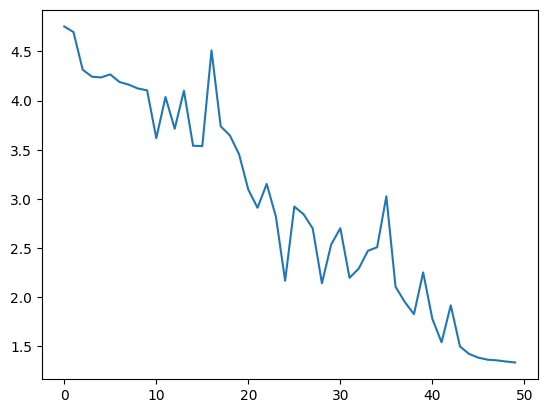

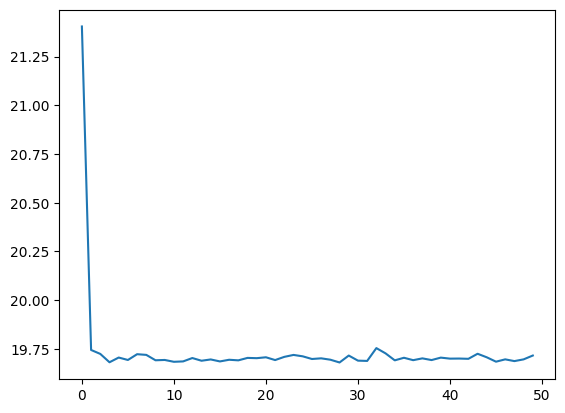

In [ ]:

import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [ ]:

s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [ ]:
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0
0,0.000000
1,0.000000


In [ ]:
values = model.critic_forward(s[[0]],actions[[0]],eval=True)
values

tensor([[0.4557]], grad_fn=<SliceBackward0>)

In [ ]:
wanna_ouput = 0.0
state_setting = 0.5 # min max
s = torch.full((1,time_step,state_size),state_setting)
r = torch.full((1,request_size),wanna_ouput)
a = model.actor_forward(s,r,eval=True)
v = model.critic_forward(s,a,eval=True)
print(f'state{s.numpy()}\n')
print(f'request{r.numpy()}\n')

state[[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
   0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
   0.5]
  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
   0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
   0.5]]]

request[[0.]]



In [ ]:
# 模型建議操作
pd.DataFrame(a[0].detach().numpy()).style.background_gradient()

,0
0,0.000000
1,0.000000


In [ ]:
# 模型預測根據上述操作應當的產出
print(f'value:{v.detach().numpy()[0][0]}\n')

value:0.4537911117076874



# r2 rse mape

In [ ]:
s = FloatTensor(data['state'])
a = FloatTensor(data['action'])
v_hat = model.critic_forward(s,a,eval=True).detach().numpy()
v_hat

array([[0.54911333],
       [0.5212252 ],
       [0.5214631 ],
       ...,
       [0.4548875 ],
       [0.45116577],
       [0.46509242]], dtype=float32)

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(v_hat,data['value'])
rmse = np.sqrt(mean_squared_error(v_hat,data['value']))
mape = mape(v_hat,data['value'])
r2,rmse,mape

(0.6287851177642457, 0.07614795819091978, 11.67179668323429)

In [ ]:
s = FloatTensor(test_data['state'])
test_data['action'] = test_data['action'].reshape(-1,2,1)
a = FloatTensor(test_data['action'])
v_hat = model.critic_forward(s,a,eval=True).detach().numpy()
r2 = r2_score(v_hat,test_data['value'])
rmse = np.sqrt(mean_squared_error(v_hat,test_data['value']))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mape(v_hat,test_data['value'].astype('float32'))
r2,rmse,mape

(-6.553098111785127, 0.15048901213532268, 22.31440842151642)

In [ ]:
result = pd.DataFrame()
result['r2'] = [r2]
result['rmse'] = [rmse]
result['mape'] = [mape]
result

,r2,rmse,mape
0,-6.553098,0.150489,22.314408
